# Model Performance
We can assess the models performance by comparing the AI's predictions to the manual corrections.

## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-image scikit-learn seaborn segmentationmetrics requests

Import required python packages

In [2]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import io
from textwrap import dedent
import numpy as np
import pandas as pd
import skimage.measure
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import segmentationmetrics as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

In [13]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

To compare model performance against the manual corrections, we need to download the dicom-seg files of the ai predictions and the manual corrections from zenodo.

In [14]:
qa_dir = Path("qa-results")

In [15]:
def download_inference(
    extract_dir="qa-results",
    url="https://zenodo.org/record/10009368/files/lung-fdg-pet-ct.zip",
):
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference()

## Data Description
The dataset was reviewed by two reviewers, a radiologist and a 'non-expert'. The non-expert was a medical student with some familiarity with radiology images. For this project, the non-expert scored every ai prediction while the radiologist only scored the validation set.

Alone with the segmentation files, we also have a qa-resulst.csv file that gives more information on the quality assessment feedback from the manual reviewers.

| column                      | description                                                                                      |
| --------------------------- | ------------------------------------------------------------------------------------------------ |
| Reviewer                    | Either `rad1` or `ne1` for Radiologist 1 and Non-expert 1 respectively                           |
| Validataion                 | if this scan was in the validation set                                                           |
| Collection                  | IDC collection name                                                                              |
| PatientID                   | PatientID from dicom                                                                             |
| StudyDate                   | StudyDate from dicom                                                                             |
| StudyDate_suffix            | incrementing value to differentiate different scans from the same StudyDate                      |
| StudyInstanceUID            | StudyInstanceUID from dicom                                                                      |
| PTSeriesInstanceUID         | SeriesInstanceUID of PET scan from dicom                                                         |
| CTSeriesInstanceUID         | SeriesInstanceUID of CT scan from dicom                                                          |
| AISegmentation              | filename of ai segmentation                                                                      |
| LikertScore                 | Reviewers opinion of how accurate the AI prediction was, see table below fr                      |
| CommentsAboutAISegmentation | comments from the reviewer about the ai segmentation, usually how the AI underperformed          |
| CommentsAboutScan           | comments from the reviewer about the scan, could be about unusual anatomy or scan artifacts.     |
| CorrectedSegmentation       | file name of the manually corrected segmentation, this file is in `qa-segmentations-dcm` folder |

The Likert scale used for scoring was:

| Score | Meaning |
| --- | --- |
| 5 | Strongly Agree - Use-as-is (i.e., clinically acceptable, and could be used for treatment without change) |
| 4 | Agree - Minor edits that are not necessary. Stylistic differences, but not clinically important. The current segmentation is acceptable |
| 3 | Neither agree nor disagree - Minor edits that are necessary. Minor edits are those that the review judges can be made in less time than starting from scratch or are expected to have minimal effect on treatment outcome |
| 2 | Disagree - Major edits. This category indicates that the necessary edit is required to ensure correctness, and sufficiently significant that user would prefer to start from the scratch |
| 1 | Strongly disagree - Unusable. This category indicates that the quality of the automatic annotations is so bad that they are unusable.|


In [16]:
df = pd.read_csv(
    qa_dir / "qa-results.csv",
    dtype={
        "PatientID": str,
        "StudyDate": str,
        "StudyDate_suffix": str,
        "LikertScore": int,
    },
)
df["CorrectedSegmentation"].fillna("", inplace=True)
df.replace(
    {"rad1": "Radiologist", "ne1": "Non-expert"},
    inplace=True,
)
# get validation subset
val_df = df[df["Validation"]]
validation_size = len(val_df["CTSeriesInstanceUID"].unique())
total_size = len(df["CTSeriesInstanceUID"].unique())
print(
    f"{validation_size/total_size*100:.2f}% of scans were validated ({validation_size}/{total_size})"
)

# get validation done by different reviewers
rad_df = val_df.loc[(val_df["Reviewer"] == "Radiologist")]
ne_df = val_df.loc[
    (val_df["Reviewer"] == "Non-expert")
    & (val_df["AISegmentation"]).isin(rad_df["AISegmentation"])
]

rad_df = rad_df.sort_values(by=["AISegmentation"])
ne_df = ne_df.sort_values(by=["AISegmentation"])

assert len(rad_df) == len(ne_df)
assert len(rad_df) == len(rad_df["AISegmentation"].unique())

print(f"{len(rad_df)} scans were reviewed by radiologist and non-expert")

10.46% of scans were validated (77/736)
77 scans were reviewed by radiologist and non-expert


We caluclate the Kendall-𝜏 score between the two reviewers. Kendall-𝜏 is a measure of correlation between raters of ordinal data. This tells us how much we can trust the scores given by the non-expert reviewer for the portion of the dataset the Radiologist did not review.
For this dataset, there is a no significant correlation between the two reviewers. 

Both reviewers rated most (66/77) of the AI predictions as 5, but they disagreed on the other ratings. This explains why the percent agreement is high, but Kendall-𝜏 is low

In [17]:
tau, p_value = stats.kendalltau(rad_df.LikertScore.values, ne_df.LikertScore.values)
print(f"Kendall's 𝜏: {tau:.2f}, p-value: {p_value:.2f}")

# Calculate percentage agreement

total_cases = len(rad_df.LikertScore)
matching_cases = np.sum(rad_df.LikertScore.values == ne_df.LikertScore.values)
percentage_agreement = (matching_cases / total_cases) * 100

print(f"Percentage Agreement: {percentage_agreement:.2f}%")

Kendall's 𝜏: 0.06, p-value: 0.60
Percentage Agreement: 66.23%


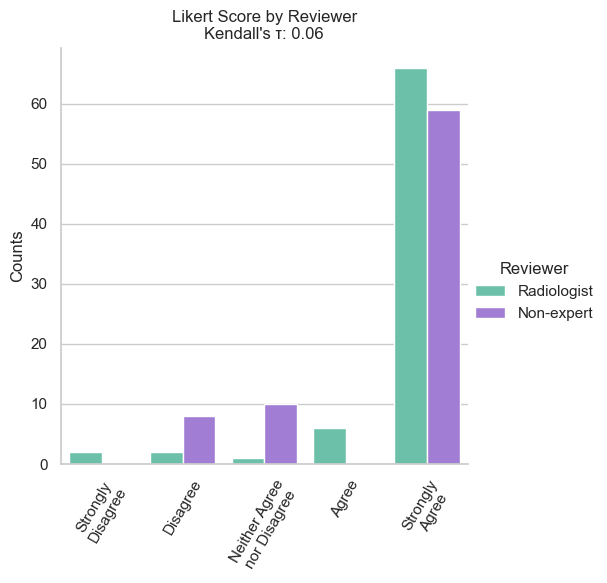

In [18]:
g = sns.catplot(
    data=val_df,
    kind="count",
    x="LikertScore",
    hue="Reviewer",
    hue_order=["Radiologist", "Non-expert"],
    palette=revewer_cmap,
)
g.set_axis_labels("", "Counts")
g.set(title=f"Likert Score by Reviewer\nKendall's \u03c4: {tau:.2f}")
g.set_xticklabels(
    labels=[
        "Strongly\nDisagree",
        "Disagree",
        "Neither Agree\nnor Disagree",
        "Agree",
        "Strongly\nAgree",
    ],
    rotation=60,
)

[Text(0.5, 20.049999999999997, 'Radiologist Likert Score'),
 Text(40.0, 0.5, 'Non-expert Likert Score'),
 (-1.0, 6.0),
 (1.0, 6.0)]

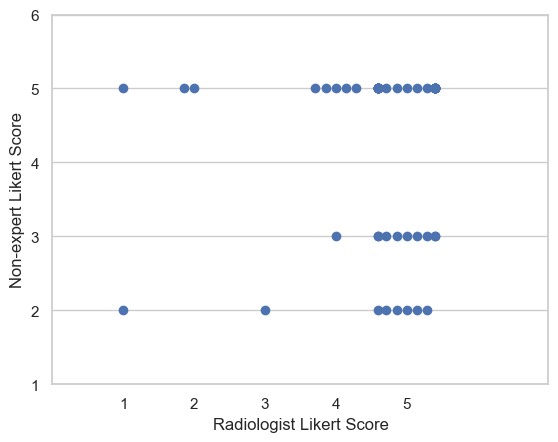

In [9]:
x = rad_df.copy()
# rename LikerScore to LikertScore_rad
x.rename(columns={"LikertScore": "LikertScore_rad"}, inplace=True)
x["LikertScore_ne"] = ne_df["LikertScore"].values

g = sns.swarmplot(x, x="LikertScore_rad", y="LikertScore_ne", size=7)
g.set(
    xlabel="Radiologist Likert Score",
    ylabel="Non-expert Likert Score",
    xlim=(-1, 6),
    ylim=(1, 6),
)

Text(0.5, 1.0, 'Likert Score Distribution for Radiologist')

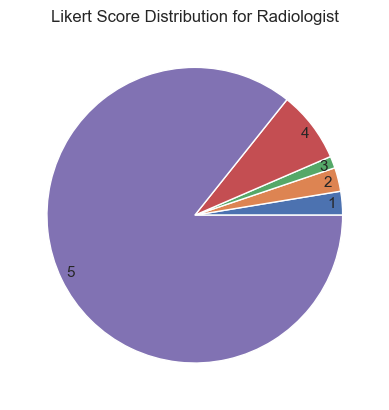

In [19]:
pie_df = (
    rad_df["LikertScore"].value_counts().reset_index().sort_values(by="LikertScore")
)
plt.pie(
    pie_df["count"].values,
    labels=pie_df["LikertScore"].values,
    labeldistance=0.9,
)
plt.title("Likert Score Distribution for Radiologist")

The reviewers also corrected the AI predictions for the validation set when their Likert rating was not 5. We can assess the reviewers agreement with the AI from segmentation metrics of Dice Similarity Coefficient (DSC), 95% Hausdorff distance.

* DSC measures volume similarity between two segmentations.
* 95% Hausdorff distance measures the agreement between surfaces. This is the distance were 95% of points on the surface are within the specified distance of the other surface.

We can also look at the detection accuracy for tumors. Tumor sizes vary and, especially with small tumors, DSC and Hausdorff distance may not be the best metrics to assess the AI's performance. Instead we can look at the detection rate and false negative & positive volume for the tumor label. Looking at the false negative & positive volume was a metric used by the [AutoPET II](https://autopet-ii.grand-challenge.org/) challenge that the model is based on.

* Detection rate measures the percentage of tumors that were detected by the ai and the reviewer. Any overlap between the ai and reviewer is considered a detection.
* False negative & positive volume measures the volume of the tumors that were detected by the ai or the reviewer. Any overlap between the ai and reviewer is considered a detection and not a false negative or positive.

In [20]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.MultiClassReader()
    result = reader.read(dcm)
    image = result.image == label
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=1, label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        # "mean_surface_distance": m.mean_surface_distance,
        # "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
        #     m._surface_dist, 7
        # ),  # from medical segmentation decathlon
    }
    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def get_false_discovery(img_file_pred: str, img_file_gt: str, label_value: int = 1):
    """Get the false discovery rate for two images, predicted (image_file_pred) and ground truth (image_file_gt)."""
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img

    vox_ml = np.prod(img_pred.GetSpacing()) / 1000

    pd_arr = sitk.GetArrayFromImage(img_pred)
    gt_arr = sitk.GetArrayFromImage(img_gt)

    pd_cc = skimage.measure.label(pd_arr)
    gt_cc = skimage.measure.label(gt_arr)
    true_pd_cc = pd_cc.copy()
    true_pd_cc[gt_cc == 0] = 0
    overlap_gt_cc = gt_cc.copy()  # gt labels that overlap with predicted
    overlap_gt_cc[pd_cc == 0] = 0

    pd_labels = np.dstack(np.unique(pd_cc, return_counts=True))[0, 1:]
    gt_labels = np.dstack(np.unique(gt_cc, return_counts=True))[0, 1:]
    true_pd_labels = np.dstack(np.unique(true_pd_cc, return_counts=True))[0, 1:]
    overlap_gt_labels = np.dstack(np.unique(overlap_gt_cc, return_counts=True))[0, 1:]

    true_vol_overlap_ml = true_pd_labels[..., 1] * vox_ml

    # get false positives
    false_pos_vols_ml = []
    for pd_label, pd_size in pd_labels:
        if pd_label not in true_pd_labels[..., 0]:
            false_pos_vols_ml.append(pd_size * vox_ml)

    # get false negatives
    false_neg_vols_ml = []
    for gt_label, gt_size in gt_labels:
        if gt_label not in overlap_gt_labels[..., 0]:
            false_neg_vols_ml.append(gt_size * vox_ml)

    return {
        "true_vol_overlap_ml": true_vol_overlap_ml,
        "false_pos_vols_ml": false_pos_vols_ml,
        "false_neg_vols_ml": false_neg_vols_ml,
        "true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        "false_pos_vol_ml_total": sum(false_pos_vols_ml),
        "false_neg_vol_ml_total": sum(false_neg_vols_ml),
        "true_vol_overlap_cnt": len(true_vol_overlap_ml),
        "false_pos_cnt": len(false_pos_vols_ml),
        "false_neg_cnt": len(false_neg_vols_ml),
    }


def add_metrics_to_df(df):
    lung_df = df.copy()
    tumors_df = df.copy()

    tumor_vols = {}
    for i, row in df.iterrows():
        ai_seg_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
        if row["LikertScore"] < 5 and row["CorrectedSegmentation"] != "":
            qa_seg_file = qa_dir / "qa-segmentations-dcm" / row["CorrectedSegmentation"]
        else:
            qa_seg_file = ai_seg_file

        assert ai_seg_file.exists()
        assert qa_seg_file.exists()

        # lungs are label 1
        metrics = calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=1)
        metrics["Label"] = "lung"
        for k, v in metrics.items():
            lung_df.at[i, k] = v

        # tumors are label 2
        detection_metrics = get_false_discovery(ai_seg_file, qa_seg_file, label_value=2)
        # extract array values into selerate dict
        tumor_vols[i] = {
            "true_vol_overlap_ml": detection_metrics.pop("true_vol_overlap_ml"),
            "false_neg_vols_ml": detection_metrics.pop("false_neg_vols_ml"),
            "false_pos_vols_ml": detection_metrics.pop("false_pos_vols_ml"),
        }

        metrics = calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=2)
        metrics["Label"] = "tumor"
        metrics.update(detection_metrics)
        for k, v in metrics.items():
            tumors_df.at[i, k] = v

    return lung_df, tumors_df, tumor_vols

In [21]:
rad_lung_df, rad_tumor_df, rad_tumor_vols = add_metrics_to_df(rad_df)
ne_lung_df, ne_tumor_df, ne_tumor_vols = add_metrics_to_df(ne_df)

all_val_df = pd.concat(
    [rad_lung_df, ne_lung_df, rad_tumor_df, ne_tumor_df], ignore_index=True
)

In [22]:
all_val_df[
    [
        "Label",
        "Reviewer",
        "dice",
        "hausdorff_distance_95",
    ]
].replace([np.inf, -np.inf], np.nan).dropna().groupby(["Label", "Reviewer"]).agg(
    {"dice": ["mean", "std"], "hausdorff_distance_95": ["mean", "std"]}
).round(2)

dice       hausdorff_distance_95       
                   mean   std                  mean    std
Label Reviewer                                            
lung  Non-expert   0.99  0.04                  1.97  10.50
      Radiologist  1.00  0.00                  0.09   0.58
tumor Non-expert   0.92  0.20                  9.99  26.35
      Radiologist  0.97  0.11                  5.83  19.42

The DSC between the reviewers is similar, which makes sense, since 66/77 scans were rated 5 and had no segmentation corrections.

However the other 11 scans had a wide range of DSC scores for both the reviewers.

There was more variation in the tumor DSC scores than lung DSC scores. This may be because tumors are smaller. Modifying a small tumor segmentation or even adding one that was missed could drasticly change the tumor DSC and leave the DSC of the larger lung roi relativly unchanged.

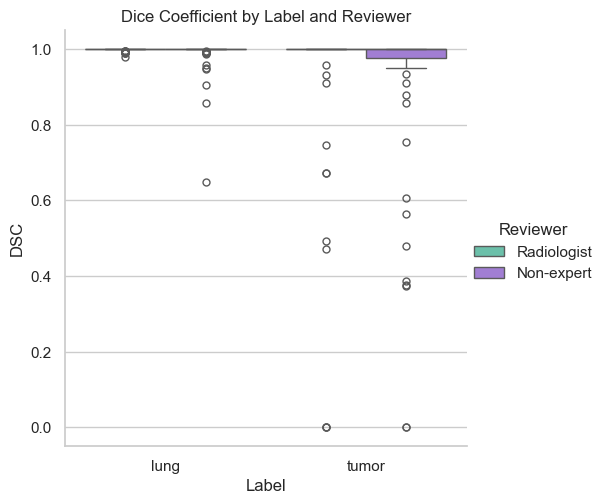

In [23]:
g = sns.catplot(
    data=all_val_df,
    x="Label",
    y="dice",
    hue="Reviewer",
    kind="box",
    palette=revewer_cmap,
)
g.set(title="Dice Coefficient by Label and Reviewer")
g.set_axis_labels("Label", "DSC")

The 95% Hausdorff distance is very low since 66/77 scans scored 5 and did not have any corrections.

Looking at the 11 scans that scored less than 5 shows interesting results for this boundary metric.
The lung boundaries were very close, but the tumor boundaries could be very far apart. That would indicate poor segmentation  large tumors or completely missed tumors.

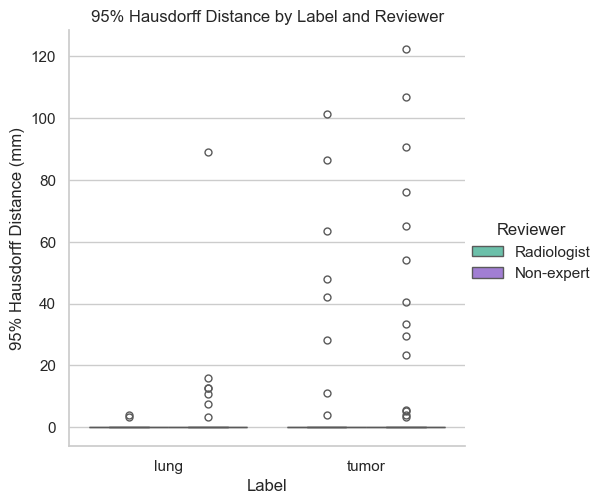

In [24]:
g = sns.catplot(
    data=all_val_df,
    x="Label",
    y="hausdorff_distance_95",
    hue="Reviewer",
    kind="box",
    palette=revewer_cmap,
)
g.set(title="95% Hausdorff Distance by Label and Reviewer")
g.set_axis_labels("Label", "95% Hausdorff Distance (mm)")

We can compare the segmentation metrics to the reviewers likert scores. DSC has a strong correlation, while 95% Hausdorff distance has a moderate correlation.

Lung:
    Radiologist: Kendall-τ: 0.92, p-value: 0.00
    Non-expert: Kendall-τ: 0.88, p-value: 0.00
Tumor:
    Radiologist: Kendall-τ: 0.98, p-value: 0.00
    Non-expert: Kendall-τ: 0.93, p-value: 0.00


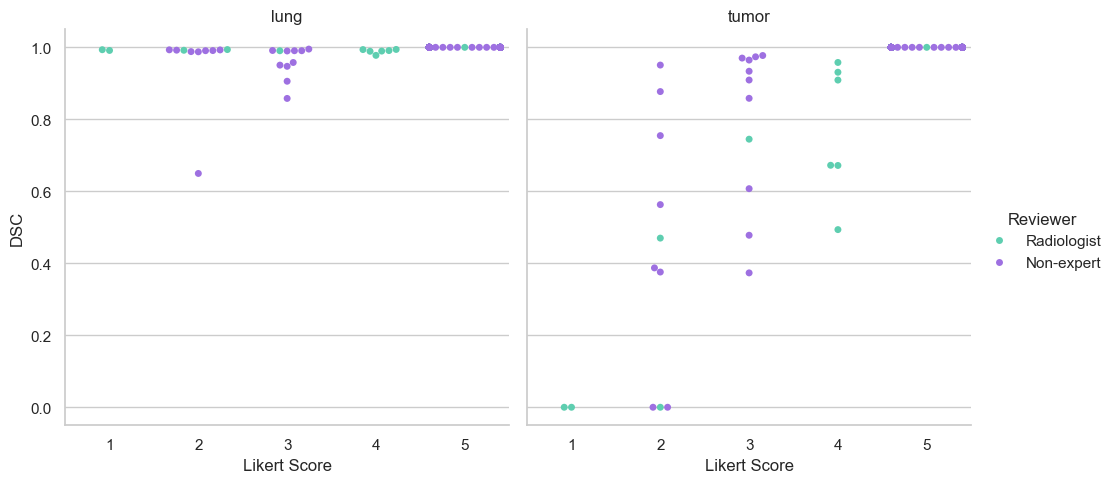

In [25]:
x = rad_lung_df[["LikertScore", "dice"]].dropna()
rad_lung_tau, rad_lung_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)
x = ne_lung_df[["LikertScore", "dice"]].dropna()
ne_lung_tau, ne_lung_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)
x = rad_tumor_df[["LikertScore", "dice"]].dropna()
rad_tumor_tau, rad_tumor_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)
x = ne_tumor_df[["LikertScore", "dice"]].dropna()
ne_tumor_tau, ne_tumor_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)

print(
    dedent(
        f"""\
        Lung:
            Radiologist: Kendall-\u03c4: {rad_lung_tau:.2f}, p-value: {rad_lung_p_value:.2f}
            Non-expert: Kendall-\u03c4: {ne_lung_tau:.2f}, p-value: {ne_lung_p_value:.2f}
        Tumor:
            Radiologist: Kendall-\u03c4: {rad_tumor_tau:.2f}, p-value: {rad_tumor_p_value:.2f}
            Non-expert: Kendall-\u03c4: {ne_tumor_tau:.2f}, p-value: {ne_tumor_p_value:.2f}"""
    )
)

# plot likert score vs dice
g = sns.catplot(
    data=all_val_df,
    kind="swarm",
    x="LikertScore",
    y="dice",
    hue="Reviewer",
    col="Label",
    palette=revewer_cmap,
)
g.set(xlabel="Likert Score", ylabel="DSC")
g.set_titles("{col_name}")

Lung:
    Radiologist: Kendall-τ: -0.36, p-value: 0.00
    Non-expert: Kendall-τ: -0.51, p-value: 0.00
Tumor:
    Radiologist: Kendall-τ: -0.63, p-value: 0.00
    Non-expert: Kendall-τ: -0.46, p-value: 0.00


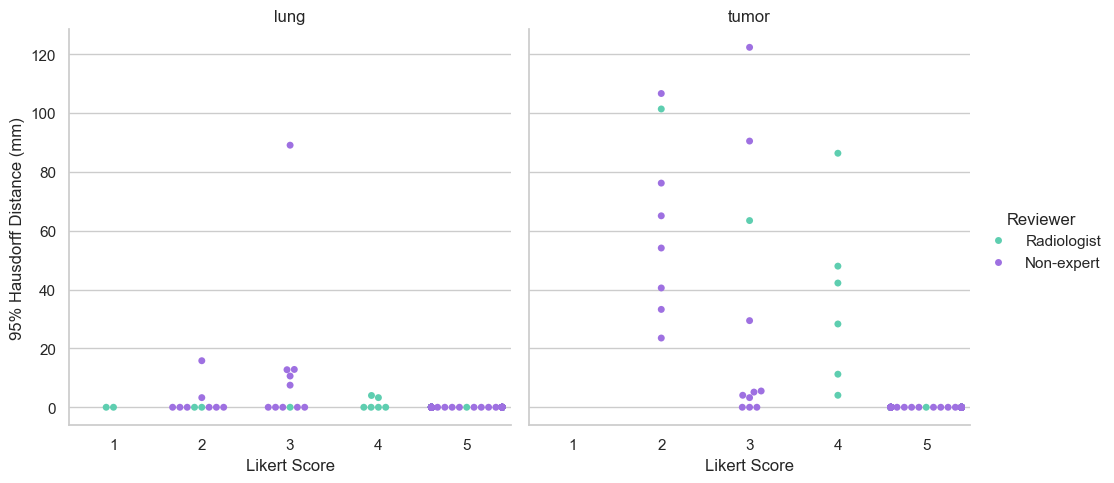

In [26]:
x = rad_lung_df[["LikertScore", "hausdorff_distance_95"]].dropna()
rad_lung_tau, rad_lung_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)
x = ne_lung_df[["LikertScore", "hausdorff_distance_95"]].dropna()
ne_lung_tau, ne_lung_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)
x = rad_tumor_df[["LikertScore", "hausdorff_distance_95"]].dropna()
rad_tumor_tau, rad_tumor_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)
x = ne_tumor_df[["LikertScore", "hausdorff_distance_95"]].dropna()
ne_tumor_tau, ne_tumor_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)
print(
    dedent(
        f"""\
        Lung:
            Radiologist: Kendall-\u03c4: {rad_lung_tau:.2f}, p-value: {rad_lung_p_value:.2f}
            Non-expert: Kendall-\u03c4: {ne_lung_tau:.2f}, p-value: {ne_lung_p_value:.2f}
        Tumor:
            Radiologist: Kendall-\u03c4: {rad_tumor_tau:.2f}, p-value: {rad_tumor_p_value:.2f}
            Non-expert: Kendall-\u03c4: {ne_tumor_tau:.2f}, p-value: {ne_tumor_p_value:.2f}"""
    )
)

# plot likert score vs 95% hausdorff distance
g = sns.catplot(
    data=all_val_df,
    kind="swarm",
    x="LikertScore",
    y="hausdorff_distance_95",
    hue="Reviewer",
    col="Label",
    palette=revewer_cmap,
)
g.set(xlabel="Likert Score", ylabel="95% Hausdorff Distance (mm)")
g.set_titles("{col_name}")

For the tumor task, we can look at the detection metrics to understand how well the AI detected individual tumors. We look at the False Positive and False Negative volumes by Likert score. The False Positive and False Negative volumes were used as a metric in the AutoPET II challenge that the model is based on.

In [27]:
# combine false_pos_vol_ml and false_neg_vol_ml into false_vol_ml, add column labet type as pos or neg
pos_df = rad_tumor_df[["false_pos_vol_ml_total", "LikertScore"]]
pos_df = pos_df.rename(columns={"false_pos_vol_ml_total": "false_vol_ml"})
pos_df["false_type"] = "false positive"

neg_df = rad_tumor_df[["false_neg_vol_ml_total", "LikertScore"]]
neg_df = neg_df.rename(columns={"false_neg_vol_ml_total": "false_vol_ml"})
neg_df["false_type"] = "false negative"

false_df = pd.concat([pos_df, neg_df], ignore_index=True)

We can look at the detection metrics to understand how well the AI identified the tumors. The Sensativity and F1 scores are very high.

In [28]:
TP = rad_tumor_df["true_vol_overlap_cnt"].sum()
FP = rad_tumor_df["false_pos_cnt"].sum()
FN = rad_tumor_df["false_neg_cnt"].sum()
rad_tumor_df["pos_cnt"] = (
    rad_tumor_df["true_vol_overlap_cnt"] + rad_tumor_df["false_pos_cnt"]
)
P = rad_tumor_df["pos_cnt"].sum()

Sensitivity = TP / P
MissRate = FN / P
F1 = 2 * TP / (2 * TP + FP + FN)

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print("")
print(f"Sensitivity: {Sensitivity:.2f}")
print(f"Miss Rate: {MissRate:.2f}")
print(f"F1: {F1:.2f}")

True Positives: 122.0
False Positives: 4.0
False Negatives: 12.0

Sensitivity: 0.97
Miss Rate: 0.10
F1: 0.94


The graph below shows that generally the false positive and false negative volumes increase as the Likert score decreases.

FP: Kendall-τ: -0.44, p-value: 0.00
FN: Kendall-τ: -0.73, p-value: 0.00


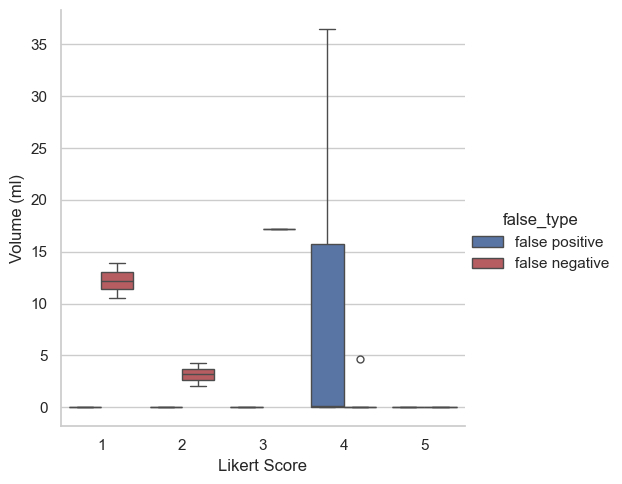

In [29]:
x = rad_tumor_df[["LikertScore", "false_pos_vol_ml_total"]].dropna()
fp_tau, fp_p_value = stats.kendalltau(
    x.LikertScore.values, x.false_pos_vol_ml_total.values
)
x = rad_tumor_df[["LikertScore", "false_neg_vol_ml_total"]].dropna()
fn_tau, fn_p_value = stats.kendalltau(
    x.LikertScore.values, x.false_neg_vol_ml_total.values
)
print(
    dedent(
        f"""\
        FP: Kendall-\u03c4: {fp_tau:.2f}, p-value: {fp_p_value:.2f}
        FN: Kendall-\u03c4: {fn_tau:.2f}, p-value: {fn_p_value:.2f}"""
    )
)

g = sns.catplot(
    data=false_df,
    x="LikertScore",
    y="false_vol_ml",
    hue="false_type",
    kind="box",
    palette=vol_cmap,
)
g.set_axis_labels("Likert Score", "Volume (ml)")

[Text(0.5, 1.0, 'Tumor Count per Case in Validation Set')]

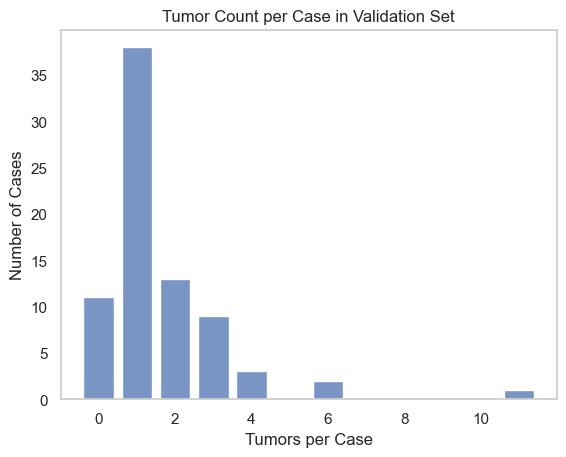

In [36]:
g = sns.histplot(
    rad_tumor_df,
    x="pos_cnt",
    binwidth=1,
    discrete=True,
    shrink=0.8,
    palette=vol_cmap,
)
g.grid(False)
g.set(xlabel="Tumors per Case")
g.set(ylabel="Number of Cases")
g.set(title="Tumor Count per Case in Validation Set")

In [33]:
rad_tumor_df["pos_cnt"].value_counts()

pos_cnt
1.0     38
2.0     13
0.0     11
3.0      9
4.0      3
6.0      2
11.0     1
Name: count, dtype: int64